C:\Users\Administrator\AppData\Local\Temp\ipykernel_10212\2714246425.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_encoded_df[f"{cat}_encoded"].fillna(train_df[target].mean(), inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10212\2714246425.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

Skewness of CO2 Emissions(g/km): 0.53
Skipping Box-Cox transformation (Skewness is within normal range).
After Standardization (y_train) Mean: Engine Size(L)                     -1.268826e-16
Cylinders                          -1.058357e-16
Fuel Consumption City (L/100 km)   -1.743885e-17
Fuel Consumption Hwy (L/100 km)    -8.142137e-16
Fuel Consumption Comb (L/100 km)    2.164822e-16
Fuel Consumption Comb (mpg)        -2.092661e-16
CO2 Emissions(g/km)                 1.070384e-16
Make_encoded                        1.061364e-16
Model_encoded                       4.437885e-16
Vehicle Class_encoded              -7.703159e-16
Transmission_encoded               -9.501164e-17
Fuel Type_encoded                   1.683751e-15
dtype: float64
After Standardization (y_train) Std: Engine Size(L)                      1.000085
Cylinders                           1.000085
Fuel Consumption City (L/100 km)    1.000085
Fuel Consumption Hwy (L/100 km)     1.000085
Fuel Consumption Comb (L/100 km)    1

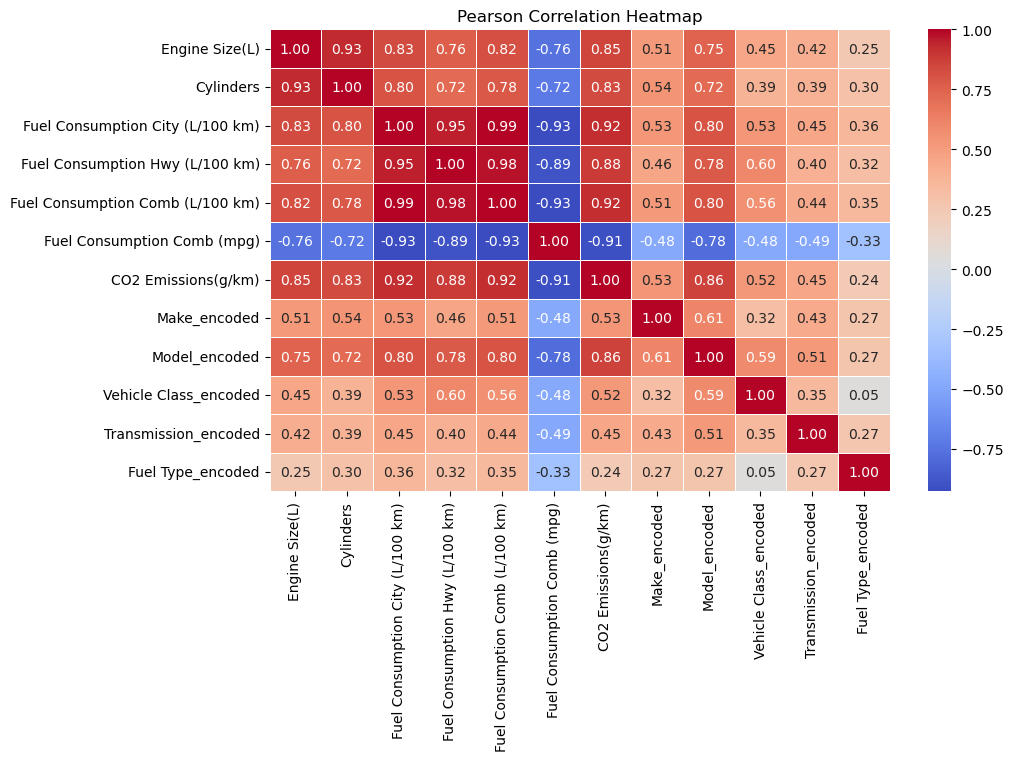


Selected Features for Model: ['Engine Size(L)', 'Fuel Consumption City (L/100 km)', 'Model_encoded']

ElasticNet Regression Model Performance:
Regularization Strength (alpha): 0.05
L1 Ratio (0 = Ridge, 1 = Lasso): 0.5
Mean Squared Error (MSE): 0.09
R-squared (R2): 0.91


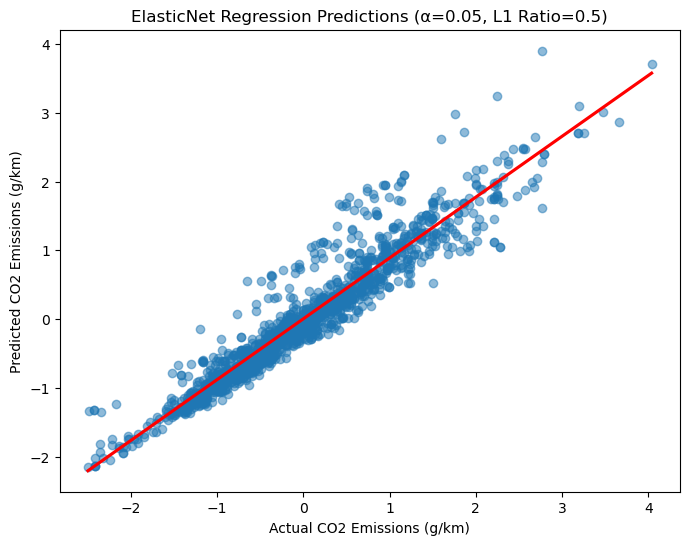

Completed all steps successfully.


In [130]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import boxcox, skew

# -------------------- 📌 Step 1: Load and Split Data --------------------
file_path = "CO2 Emissions_Canada.csv"
data_df = pd.read_csv(file_path)

# Define numerical and categorical features
numeric_features = ["Engine Size(L)", "Cylinders", "Fuel Consumption City (L/100 km)", 
                    "Fuel Consumption Hwy (L/100 km)", "Fuel Consumption Comb (L/100 km)", 
                    "Fuel Consumption Comb (mpg)"]
categorical_features = ["Make", "Model", "Vehicle Class", "Transmission", "Fuel Type"]
target = "CO2 Emissions(g/km)"

# Split Data
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

# -------------------- 📌 Step 2: Apply KFold Target Encoding on Categorical Features --------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_encoded_df = train_df.copy()
for cat in categorical_features:
    train_encoded_df[f"{cat}_encoded"] = np.nan  
    for train_idx, val_idx in kf.split(train_df):
        fold_train = train_df.iloc[train_idx]
        target_mean = fold_train.groupby(cat)[target].mean()
        valid_idx = train_encoded_df.index.intersection(val_idx)
        train_encoded_df.loc[valid_idx, f"{cat}_encoded"] = train_df.loc[valid_idx, cat].map(target_mean)
    train_encoded_df[f"{cat}_encoded"].fillna(train_df[target].mean(), inplace=True)

test_encoded_df = test_df.copy()
for cat in categorical_features:
    overall_mapping = train_df.groupby(cat)[target].mean()
    test_encoded_df[f"{cat}_encoded"] = test_df[cat].map(overall_mapping)
    test_encoded_df[f"{cat}_encoded"].fillna(train_df[target].mean(), inplace=True)

train_encoded_df.drop(columns=categorical_features, inplace=True)
test_encoded_df.drop(columns=categorical_features, inplace=True)

# -------------------- 📌 Step 3: Check Skewness and Apply Box-Cox Transformation (Optional) --------------------
skewness_value = skew(train_df[target])
apply_boxcox = False if -1 <= skewness_value <= 1 else True

print(f"Skewness of {target}: {skewness_value:.2f}")
if apply_boxcox:
    print("Applying Box-Cox transformation...")
    train_encoded_df[target], lambda_value = boxcox(train_encoded_df[target] + 1)  # Adding 1 to avoid zero values
    test_encoded_df[target] = boxcox(test_encoded_df[target] + 1, lmbda=lambda_value)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(train_df[target], bins=30, kde=True, ax=ax[0], color="blue")
    ax[0].set_title("Original CO2 Emissions Distribution")
    sns.histplot(train_encoded_df[target], bins=30, kde=True, ax=ax[1], color="green")
    ax[1].set_title(f"Box-Cox Transformed CO2 Emissions (λ = {lambda_value:.2f})")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Box-Cox transformation (Skewness is within normal range).")

# -------------------- 📌 Step 4: Standardize Data --------------------
apply_standardization = True

if apply_standardization:
    scaler = StandardScaler()
    train_encoded_df = pd.DataFrame(scaler.fit_transform(train_encoded_df), columns=train_encoded_df.columns, index=train_encoded_df.index)
    test_encoded_df = pd.DataFrame(scaler.transform(test_encoded_df), columns=test_encoded_df.columns, index=test_encoded_df.index)
    print("After Standardization (y_train) Mean:", train_encoded_df.mean())
    print("After Standardization (y_train) Std:", train_encoded_df.std())
    print("Standardization applied.")
else:
    print("Standardization is turned off.")

# -------------------- 📌 Step 5: Compute Pearson Correlation --------------------
correlation_matrix = train_encoded_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Heatmap")
plt.show()

# -------------------- 📌 Step 6: Remove Highly Correlated Features (> 90%) --------------------
selected_features = []
for col in correlation_matrix.columns:
    drop_flag = False
    for kept in selected_features:
        if correlation_matrix.loc[col, kept] > 0.9:
            drop_flag = True
            break
    if not drop_flag:
        selected_features.append(col)

# -------------------- 📌 Step 7: Select Features with Correlation > 70% with Target --------------------
correlation_threshold = 0.7
high_corr_features = [feature for feature in selected_features if correlation_matrix[target][feature] > correlation_threshold]

print("\nSelected Features for Model:", high_corr_features)

# -------------------- 📌 Step 8: Train ElasticNet Regression Model --------------------
alpha = 0.05  # Regularization strength
l1_ratio = 0.5  # 0 = Ridge, 1 = Lasso, 0.5 = ElasticNet

model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
model.fit(train_encoded_df[high_corr_features], train_encoded_df[target])

# Make predictions
y_pred = model.predict(test_encoded_df[high_corr_features])

# -------------------- 📌 Step 9: Evaluate Model --------------------
mse = mean_squared_error(test_encoded_df[target], y_pred)
r2 = r2_score(test_encoded_df[target], y_pred)

print("\nElasticNet Regression Model Performance:")
print(f"Regularization Strength (alpha): {alpha}")
print(f"L1 Ratio (0 = Ridge, 1 = Lasso): {l1_ratio}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# -------------------- 📌 Step 10: Plot Predictions --------------------
plt.figure(figsize=(8, 6))
sns.regplot(x=test_encoded_df[target], y=y_pred, scatter_kws={'alpha': 0.5}, line_kws={"color": "red"}, ci=None)
plt.xlabel("Actual CO2 Emissions (g/km)")
plt.ylabel("Predicted CO2 Emissions (g/km)")
plt.title(f"ElasticNet Regression Predictions (α={alpha}, L1 Ratio={l1_ratio})")
plt.show()

print("Completed all steps successfully.")
